In [2]:
import os
import re
import gensim.downloader as api
import nltk
import numpy as np
import pandas as pd
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from nltk.stem import PorterStemmer

In [3]:
nltk.download('stopwords')
nltk.download('wordnet')
# Load GloVe model with Gensim's API
embeddings_model = api.load("glove-twitter-200")  # 200-dimensional GloVe embeddings

[nltk_data] Downloading package stopwords to
[nltk_data]     /users/eleves-b/2022/aziz.bacha/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /users/eleves-b/2022/aziz.bacha/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [4]:
def get_avg_embedding(tweet, model, vector_size=200):
    words = tweet.split()  # Tokenize by whitespace
    word_vectors = [model[word] for word in words if word in model]
    if not word_vectors:  # If no words in the tweet are in the vocabulary, return a zero vector
        return np.zeros(vector_size)
    return np.mean(word_vectors, axis=0)

In [5]:
# Remove stopwords
stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()

# Basic preprocessing function
def preprocess_text(text):
    # Remove URLs
    text = re.sub(r'http\S+', '', text)
    # Lowercasing
    text = text.lower()
    # Remove punctuation
    text = re.sub(r'[^\w\s]', '', text)
    # Tokenization
    words = text.split()
    
    words = [word for word in words if word not in stop_words]
    # Lemmatization
    lemmatizer = WordNetLemmatizer()
    words = [lemmatizer.lemmatize(word) for word in words]
    return ' '.join(words)


In [6]:
from collections import defaultdict

# Dictionary of keywords by sub-event type
keywords = {
    "goal": [
        "goal", "golazo", "scored",
        "equalizer","oaaaal","ooooa", "ooaaa","gooal","goaaaa","alll","!!!"
    ],
    "penalty": [
        "penalty", "spot kick",
    ],
    "red_card": [
        "red card", "sent off", "redcard", "ejected", "foul play",
        "dangerous tackle"
    ],
    "yellow_card": [
        "yellow card", "cautioned", "warned","yellowcard"
    ],
    "kick_off": [
        "kickoff", "game started", "match begins", "we'?re live",
        "first whistle", "kick off", "kick-off"
    ],
    "half_time": [
        "half time", "halftime", "half-time", "break time",
         "half over", "interval"
    ],
    "full_time": [
        "full time", "fulltime", "full-time"
        , "match over", "whistle",
        "game over"
    ],
    "own_goal": [
        "own goal","owngoal", "scored on themselves",
    ]
}

compiled_keywords = {}
for event_type, kw_list in keywords.items():
    # Escape keywords and join with '|'
    pattern = '|'.join(re.escape(kw) for kw in kw_list)
    # Replace spaces with '\s+' to match any whitespace
    pattern = pattern.replace(r'\ ', r'\s+')
    # Compile the regex pattern, case-insensitive and Unicode
    compiled_keywords[event_type] = re.compile(pattern, re.IGNORECASE | re.UNICODE)

In [7]:
li = []
for filename in os.listdir("train_tweets"):
    df = pd.read_csv("train_tweets/" + filename)
    print("Reading", filename)
    li.append(df)
df = pd.concat(li, ignore_index=True)

Reading GermanyBrazil74.csv
Reading ArgentinaBelgium72.csv
Reading AustraliaNetherlands29.csv
Reading ArgentinaGermanyFinal77.csv
Reading FranceGermany70.csv
Reading FranceNigeria66.csv
Reading GermanyAlgeria67.csv
Reading GermanyUSA57.csv
Reading AustraliaSpain34.csv
Reading BelgiumSouthKorea59.csv
Reading CameroonBrazil36.csv
Reading HondurasSwitzerland54.csv
Reading MexicoCroatia37.csv
Reading NetherlandsChile35.csv
Reading PortugalGhana58.csv
Reading USASlovenia2010.csv


In [8]:
# Removing duplicates and retweets
df.drop_duplicates(subset=['Tweet'], inplace=True)
df = df[~df['Tweet'].str.startswith('RT ')]

df = df.reset_index(drop=True)

In [10]:
df['Tweet'] = df['Tweet'].apply(preprocess_text)

In [11]:
def detect_keywords(tweet, compiled_keywords):
    detected = defaultdict(int)
    for event_type, pattern in compiled_keywords.items():
        if pattern.search(tweet):
            detected[event_type] = 1
    return detected

In [12]:
df['DetectedEvents'] = df['Tweet'].apply(lambda x: detect_keywords(x, compiled_keywords))
df['DetectedEvents'] = df['DetectedEvents'].apply(lambda events: sum(events.values()))

In [13]:
df['DetectedEvents'].value_counts()

DetectedEvents
0    2049597
1     260875
2       5614
3         89
4          3
Name: count, dtype: int64

In [14]:
vector_size = 200  # Adjust based on the chosen GloVe model
tweet_vectors = np.vstack([get_avg_embedding(tweet, embeddings_model, vector_size) for tweet in df['Tweet']])
tweet_df = pd.DataFrame(tweet_vectors)

In [15]:
period_features = pd.concat([df, tweet_df], axis=1)

In [16]:
period_features = period_features.drop(columns=['Timestamp', 'Tweet'])

detected_events_sum = period_features.groupby(['MatchID', 'PeriodID', 'ID'])['DetectedEvents'].sum().reset_index()

period_features = period_features.drop(columns=['DetectedEvents'])

period_features = period_features.groupby(['MatchID', 'PeriodID', 'ID']).mean().reset_index()

period_features.insert(4, 'DetectedEvents', detected_events_sum['DetectedEvents'])

In [17]:
tweet_counts = df.groupby(['MatchID', 'PeriodID', 'ID']).size().reset_index(name='TweetCount').drop(columns=['MatchID', 'PeriodID', 'ID'])
period_features.insert(5, 'TweetCount', tweet_counts['TweetCount'])

In [18]:
period_features.head()

,MatchID,PeriodID,ID,EventType,DetectedEvents,TweetCount,0,1,2,3,...,190,191,192,193,194,195,196,197,198,199
0,0,0,0_0,0.0,5,82,0.095443,0.207692,0.030330,-0.109780,...,-0.023742,-0.054686,0.042194,0.015927,-0.088707,0.032012,0.236772,0.087780,-0.005269,0.124383
1,0,1,0_1,0.0,3,71,0.119098,0.218118,0.027156,-0.131639,...,-0.030083,-0.049377,0.036753,-0.006270,-0.132416,0.047154,0.229333,0.106552,-0.006598,0.111176
2,0,2,0_2,0.0,5,83,0.078627,0.199274,0.048089,-0.153070,...,-0.031361,-0.049134,0.044051,0.020548,-0.106693,0.050208,0.235802,0.082216,-0.014229,0.122426
3,0,3,0_3,0.0,4,96,0.086171,0.200241,0.013364,-0.127577,...,-0.029445,-0.050806,0.045777,0.002460,-0.103733,0.030065,0.242277,0.090043,0.000691,0.114112
4,0,4,0_4,0.0,4,143,0.092514,0.209283,-0.030375,-0.104870,...,-0.040745,-0.055143,0.024935,0.029452,-0.124541,0.050561,0.229511,0.128974,-0.042124,0.161003


In [19]:
# We drop the non-numerical features and keep the embeddings values for each period
X = period_features.drop(columns=['MatchID','ID','EventType']).values
y = period_features['EventType'].values

XGBoost model

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

from sklearn.metrics import accuracy_score
import xgboost as xgb

xgb_clf = xgb.XGBClassifier(
    objective='binary:logistic',  
    eval_metric='logloss',       
    n_estimators=100,            
    learning_rate=0.1,           
    max_depth=6,                 
    random_state=42              
)

xgb_clf.fit(X_train, y_train)

# Make predictions
y_pred = xgb_clf.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("XGBoost Classifier Accuracy:", accuracy)

XGBoost Classifier Accuracy: 0.7772585669781932


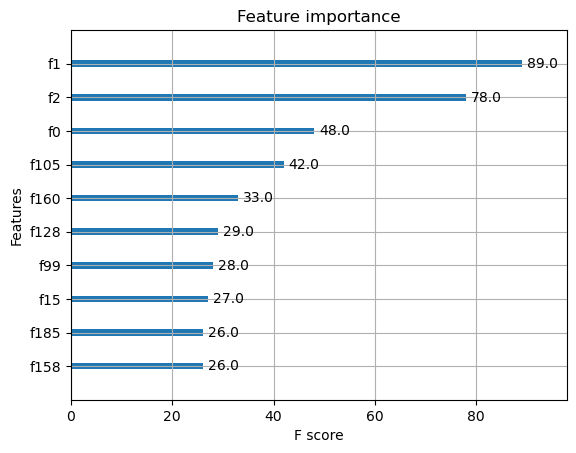

In [21]:
# plot feature importance
import matplotlib.pyplot as plt
from xgboost import plot_importance

plot_importance(xgb_clf, max_num_features=10, importance_type='weight')
plt.show()

Random Forest model:
 
we will use a GridSearchCV for hyperparameter tuning 

In [22]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
param_grid = {
    'n_estimators': [100, 500, 1000],    
    'max_depth': [5, 10, None],          
    'min_samples_split': [2, 5],         
    'min_samples_leaf': [1, 2],          
    'max_features': ['sqrt', 'log2']     
}

rf_clf = RandomForestClassifier(random_state=42)

grid_search = GridSearchCV(
    estimator=rf_clf, 
    param_grid=param_grid, 
    cv=3,                        
    scoring='accuracy',          
    verbose=1   ,                   
    n_jobs=-1                    
)

grid_search.fit(X_train, y_train)

print("Best Parameters:", grid_search.best_params_)
print("Best Cross-Validation Accuracy:", grid_search.best_score_)


Fitting 3 folds for each of 72 candidates, totalling 216 fits
Best Parameters: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 500}
Best Cross-Validation Accuracy: 0.7505117329706267


In [23]:
from sklearn.metrics import classification_report
# Use the best model for predictions
best_rf_clf = grid_search.best_estimator_
y_pred = best_rf_clf.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Test Set Accuracy:", accuracy)
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Test Set Accuracy: 0.7881619937694704

Classification Report:
              precision    recall  f1-score   support

         0.0       0.80      0.72      0.76       300
         1.0       0.78      0.85      0.81       342

    accuracy                           0.79       642
   macro avg       0.79      0.78      0.79       642
weighted avg       0.79      0.79      0.79       642



In [24]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import numpy as np

mlp_clf = Pipeline([
    ('scaler', StandardScaler()),  
    ('mlp', MLPClassifier(
        hidden_layer_sizes=(128, 64),  
        activation='relu',            
        solver='adam',                
        alpha=0.0001,                 
        learning_rate='adaptive',     
        max_iter=500,                 
        random_state=42               
))])

mlp_clf.fit(X_train, y_train)

y_pred = mlp_clf.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("MLP Classifier Accuracy:", accuracy)

print("\nClassification Report:\n")
print(classification_report(y_test, y_pred))


MLP Classifier Accuracy: 0.7585669781931464

Classification Report:

              precision    recall  f1-score   support

         0.0       0.76      0.71      0.73       300
         1.0       0.76      0.80      0.78       342

    accuracy                           0.76       642
   macro avg       0.76      0.76      0.76       642
weighted avg       0.76      0.76      0.76       642



In [25]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report

results = {}
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
classifiers = {'XGBoost': xgb_clf, 'Random Forest': best_rf_clf, 'MLP': mlp_clf}

for name, clf in classifiers.items():
    y_pred = clf.predict(X_test)
    y_proba = clf.predict_proba(X_test)[:, 1] if hasattr(clf, 'predict_proba') else None

    results[name] = {
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred, average='weighted'),
        'F1-Score': f1_score(y_test, y_pred, average='weighted'),
        'ROC-AUC': roc_auc_score(y_test, y_proba) if y_proba is not None else None
    }


In [26]:
results_df = pd.DataFrame(results).T
results_df.reset_index(inplace=True)
results_df.rename(columns={'index': 'Classifier'}, inplace=True)

results_df

,Classifier,Accuracy,Precision,F1-Score,ROC-AUC
0,XGBoost,0.777259,0.777083,0.776941,0.869474
1,Random Forest,0.788162,0.789415,0.787038,0.875097
2,MLP,0.758567,0.758538,0.757882,0.840760
